
Processing algorithm: CQL_20251121213240


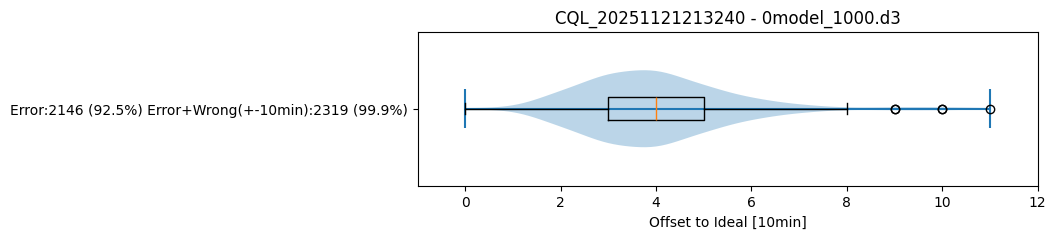

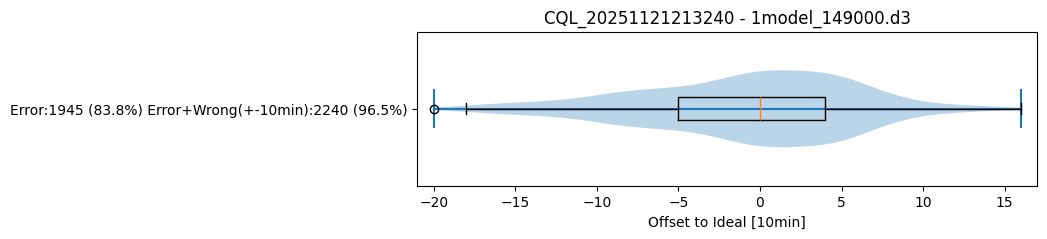

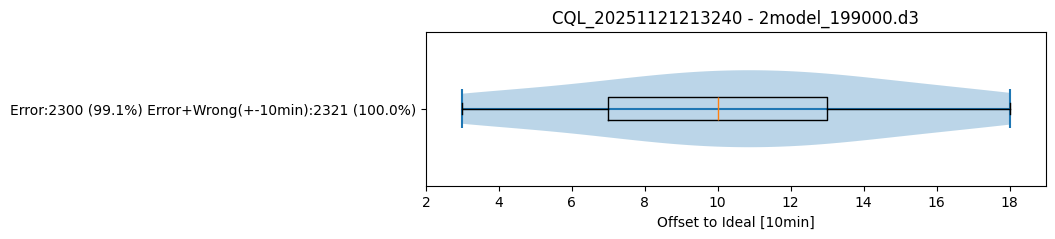

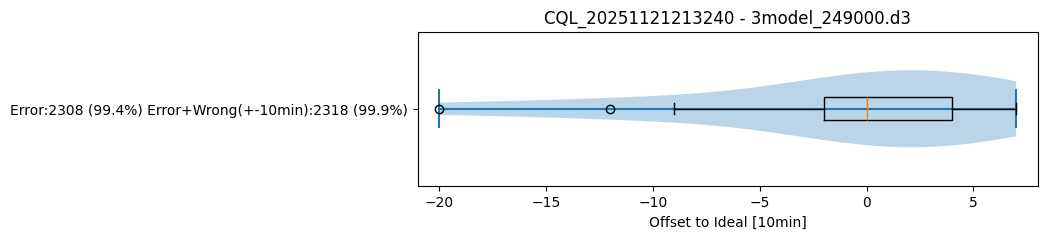

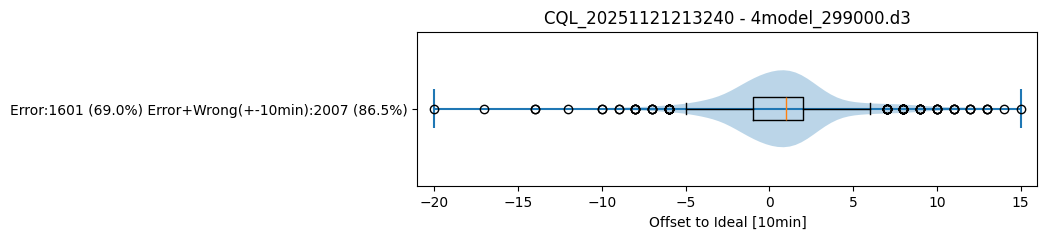

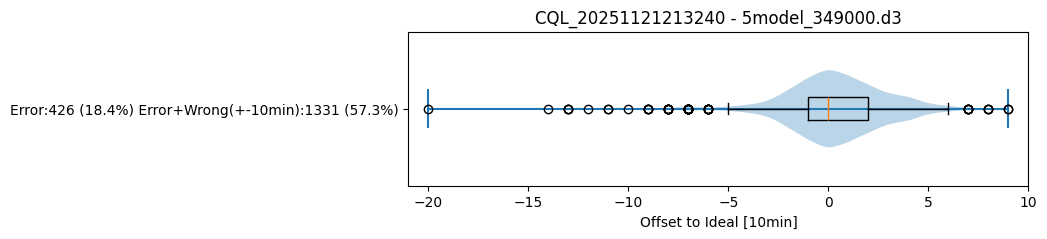

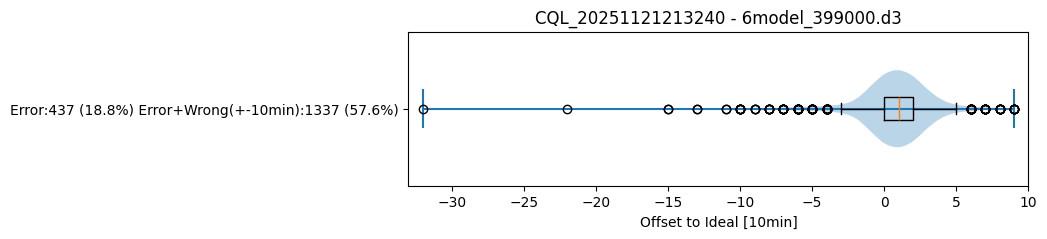

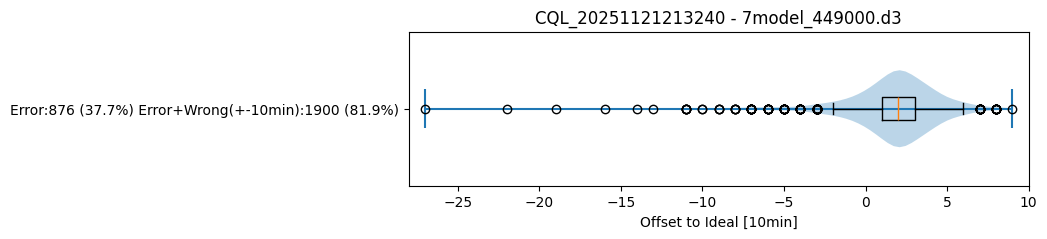

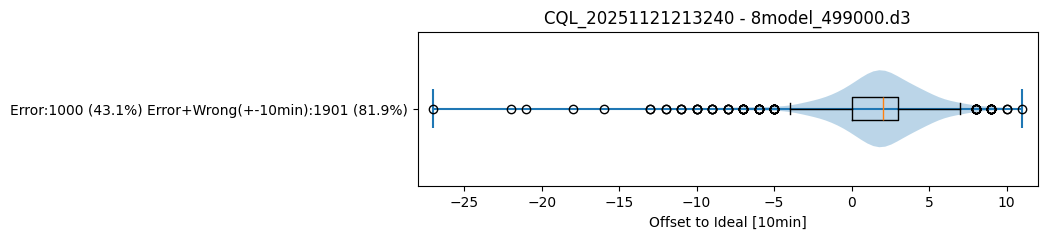

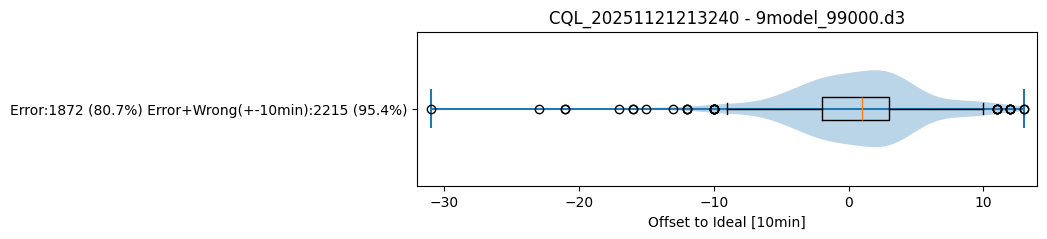

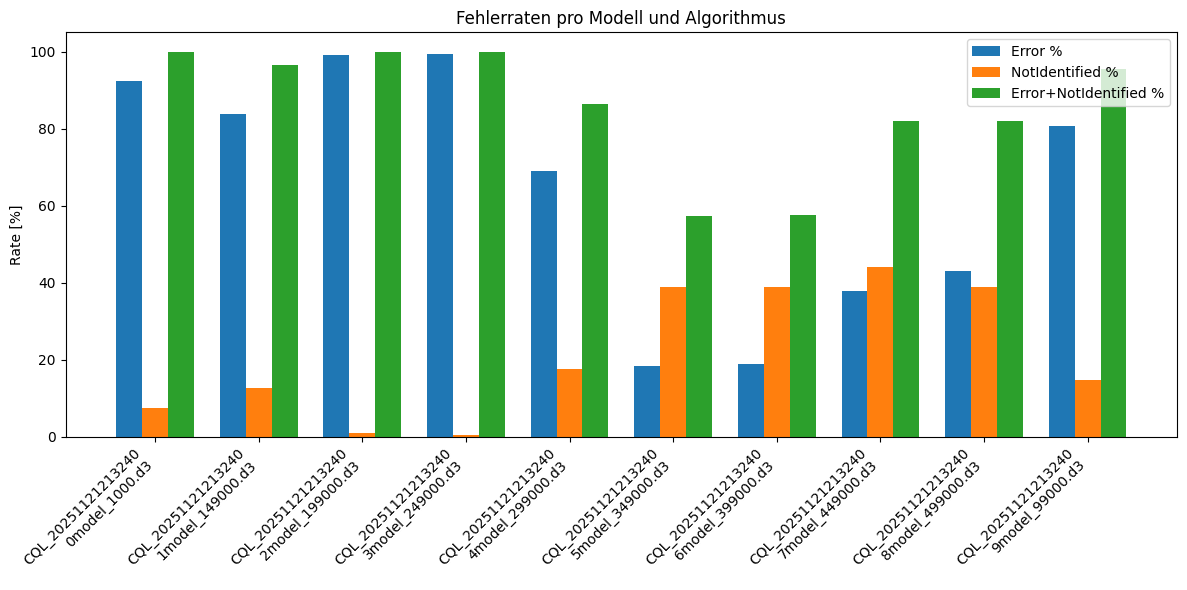


Processing algorithm: PLAS_20251123125017


c:\Users\NilsWindows\Desktop\research2.0\.venv\lib\site-packages\d3rlpy\torch_utility.py:431: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  chkpt = torch.load(f, map_locatio

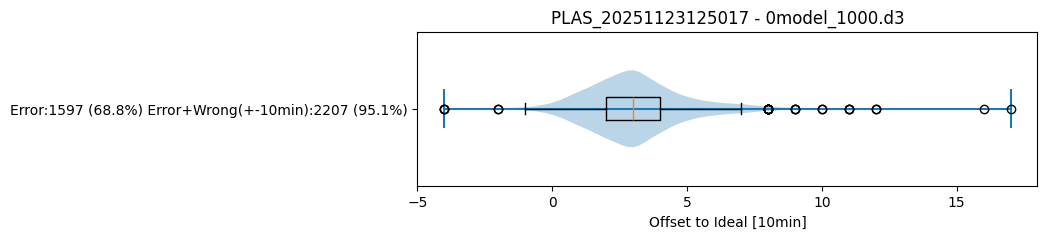

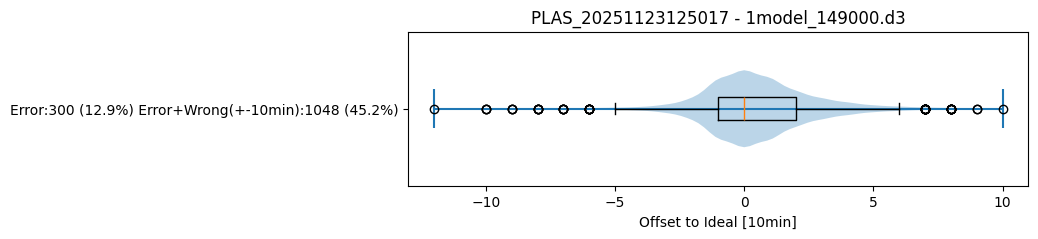

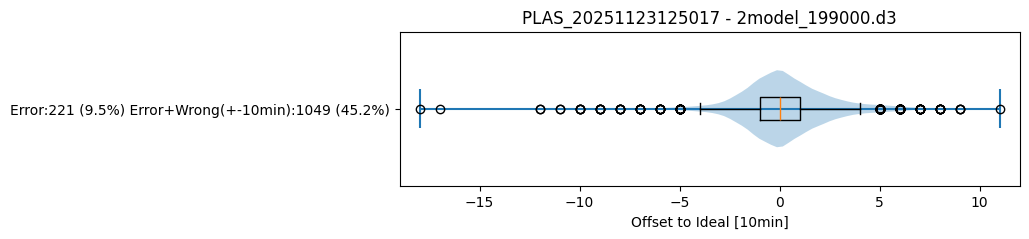

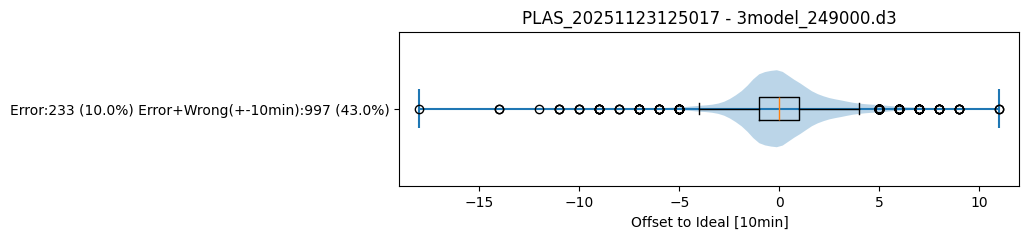

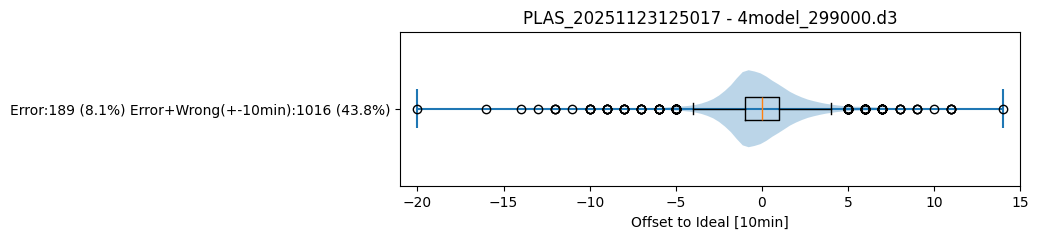

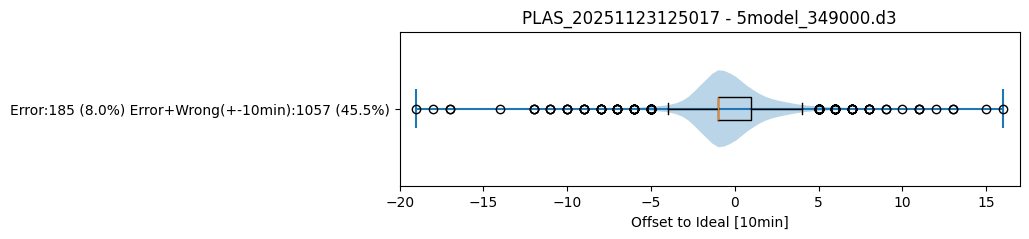

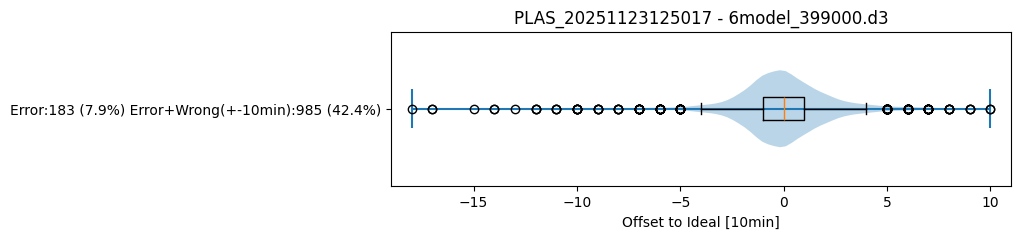

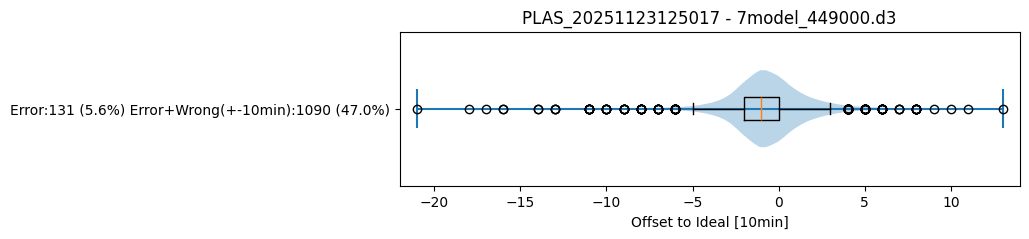

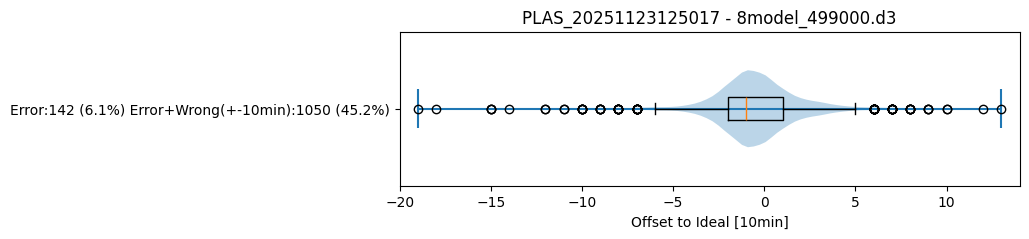

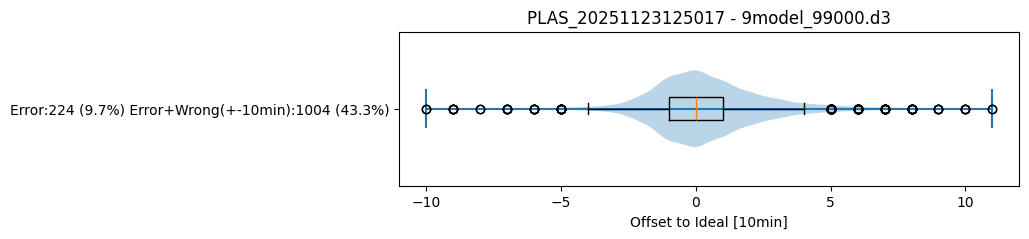

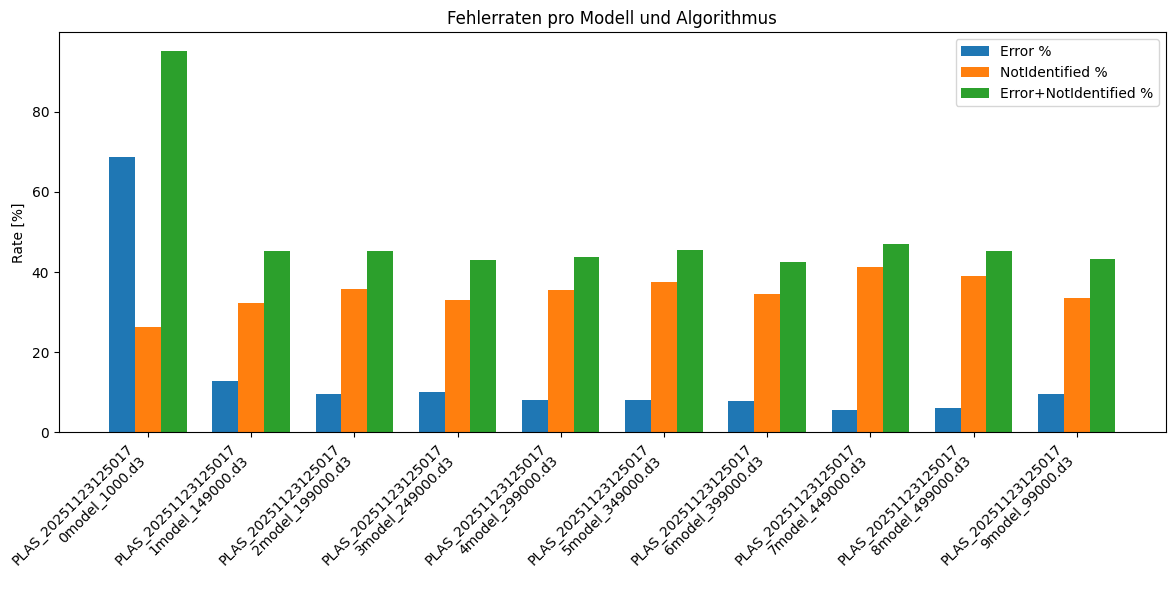

In [15]:
#ToDo neues Datenset erzeugen mit nur idealen episoden um herauszufinden wie gut die Modelle wirklich sind 
#ToDo aus den real dAten muss auch ein datensatz gemacht werden um zu schauen wie gut die Modelle auf real daten sind
#      Dabei auf die Werte achten muss seleb Form wie bei den Trainingsdaten haben


import os
import numpy as np
import d3rlpy
import csv
import matplotlib.pyplot as plt

def read_Episodes(baseFolder):
    episodes = []
    for filename in sorted(os.listdir(baseFolder)):
        filePath = os.path.join(baseFolder, filename)
        episode = []
        with open(filePath, "r", newline="") as file:
            reader = csv.reader(file)
            for row in reader:
                observation = [float(epi) for epi in row]
                episode.append(observation)
            episodes.append(episode)
    return episodes

def load_models_from_training(training_dir):
    models = []
    model_files = sorted([f for f in os.listdir(training_dir) if f.endswith('.d3')])
    
    if len(model_files) > 10:
        step = (len(model_files) - 1) / 9
        selected_indices = [int(i * step) for i in range(9)]
        selected_indices.append(len(model_files) - 1)
        selected_indices = sorted(list(set(selected_indices)))
        model_files = [model_files[i] for i in selected_indices]
    for i,model_file in enumerate(model_files):
        model_path = os.path.join(training_dir, model_file)
        try:
            model = d3rlpy.load_learnable(model_path)
            models.append(((str(i)+model_file), model))
        except Exception as e:
            print(f"Error loading {model_file}: {e}")
    return models

# ==== Hauptfunktion ====
base_dir = "test logs"  # Passe ggf. an
#testEpisode = "../data/episFormula/3.2 test für 2.0/"  # Passe ggf. an
testEpisode = "../data/episFormula/3.1 for Test_2 Times epi length"


if os.path.exists(base_dir):
    algorithm_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    for algorithm_name in algorithm_dirs:
        # Arrays für spätere Auswertung
        model_names = []
        algo_names = []
        error_rates = []
        not_identified_rates = []
        total_error_rates = []
        algorithm_path = os.path.join(base_dir, algorithm_name)
        print(f"\nProcessing algorithm: {algorithm_name}")
        models = load_models_from_training(algorithm_path)
        if not models:
            print(f"No models found in {algorithm_path}")
            continue
        episodes = read_Episodes(testEpisode)
        for i, (model_name, model) in enumerate(models):
            soll_ist_diff = []
            totalError = 0
            not_identified = 0
            wrongEpisode = 0
            for samples in episodes:
                prediction = []
                for sample in samples:
                    obs = np.array([sample[:-3]])
                    try:
                        pred = model.predict(obs)[0]
                    except Exception as e:
                        pred = 0
                    prediction.append(pred)
                soll_idx = next((i for i, v in enumerate([sample[-1] for sample in samples]) if v > 0), None)
                ist_idx = next((i for i, v in enumerate(prediction) if v <= 10), None)
                if  ist_idx is None:
                    totalError += 1
                elif soll_idx is None:
                    wrongEpisode += 1
                    Warning("Soll Index nicht gefunden in Episode")
                else:
                    abweichung = ist_idx + 1 - soll_idx
                    soll_ist_diff.append(abweichung)
                    if not (-1 <= abweichung <= 1):
                        not_identified += 1
            n_valid = len(episodes) - wrongEpisode
            if len(soll_ist_diff) > 0 and n_valid > 0:
                wrong_predicted = ((totalError + not_identified) / n_valid) * 100
                error_percent = (totalError / n_valid) * 100
                not_identified_percent = (not_identified / n_valid) * 100
                # Arrays befüllen
                model_names.append(model_name)
                algo_names.append(algorithm_name)
                error_rates.append(error_percent)
                not_identified_rates.append(not_identified_percent)
                total_error_rates.append(wrong_predicted)
                plt.figure(figsize=(8,2))
                plt.violinplot(soll_ist_diff, vert=False)
                plt.boxplot(soll_ist_diff, vert=False, tick_labels=[f"Error:{totalError} ({error_percent:.1f}%) Error+Wrong(+-10min):{not_identified+totalError} ({wrong_predicted:.1f}%)"])
                plt.title(f"{algorithm_name} - {model_name}")
                plt.xlabel("Offset to Ideal [10min]")
                plt.xlim(min(soll_ist_diff) - 1, max(soll_ist_diff) + 1)
                plt.show()
            else:
                print(f"Keine Differenzen für {model_name} ({algorithm_name}) zum Plotten vorhanden. Fehlerhafte Episoden: {totalError}")

        # Zusammenfassende Visualisierung
        import pandas as pd
        plt.figure(figsize=(12,6))
        #reset parameters for
        summary_df = pd.DataFrame({
            "Algorithmus": algo_names,
            "Modell": model_names,
            "Error %": error_rates,
            "NotIdentified %": not_identified_rates,
            "Total Error %": total_error_rates
        })
        x = np.arange(len(summary_df))
        width = 0.25
        plt.bar(x - width, summary_df["Error %"], width=width, label="Error %")
        plt.bar(x, summary_df["NotIdentified %"], width=width, label="NotIdentified %")
        plt.bar(x + width, summary_df["Total Error %"], width=width, label="Error+NotIdentified %")
        plt.xticks(x, [f"{a}\n{m}" for a, m in zip(summary_df["Algorithmus"], summary_df["Modell"])], rotation=45, ha="right")
        plt.ylabel("Rate [%]")
        plt.title("Fehlerraten pro Modell und Algorithmus")
        plt.legend()
        plt.tight_layout()
        plt.show()
else:
    print(f"Directory {base_dir} not found!")